## **Введение**

### Цель работы:
  - изучить метод разностных аппроксимаций, составить алгоритм метода и программу их реализации, получить численное решение заданной краевой задачи;
  - составить алгоритм решения краевых задач указанными методами, применимыми для организации вычислений на ПЭВМ;
  - составить программу решения краевых задач по разработанному алгоритму.
  - выполнить тестовые примеры и проверить правильность работы программ.

### Условия задания

Условия задания были выбраны исходя из варианта

In [ ]:
VARIANT_NUMBER = 2

### Краткие теоретические сведения

Рассмотрим краевую задачу $$ 
   \begin{cases}
        y'' = f(x, y, y'),  x \in (a, b) \\
        y(a) = A\\
        y(b) = B
    \end{cases} \\
$$ 
Разобьем отрезок $[a, b]$ на $n$ одинаковых частей с шагом $h = \frac{b - a}{n}$ точками:
$$a = x_0 < x_1 < ... < x_n - b$$ 
Заменим производные на их разностные отношения (при этом разностное отношение будет приближать производную с порядком $O(h^2)$)
$$y'(x_k) = \frac{y_{k+1} - y_k}{2h}  \\
y''(x_k) = \frac{y_{k+1} - 2y_k + y_{k-1}}{h^2} $$  
где $y_k = y(x_k) \forall k \in (1, n-1)$. Получим для любого внутреннего узла $x_k, k \in (1, n - 1)$ уравнение: 
$$\frac{y_{k+1} - 2y_k + y_{k-1}}{h^2} = f\Biggr(x_k, y_k, \frac{y_{k+1} - y_{k-1}}{2h}\Biggr) $$  и для граничных узлов $y_0 = A, y_n = B$

То есть, мы имеем систему из $(n+1)$ уравнений с $(n+1)$ неизвестными $y_k$. Ее решение дает нам приближенное решение краевой задачи. При этом, если использовать разностную схему с разностными отношениями выше, матрица системы линейных уравнений сведется к трехдиагональной и тогда такую систему можно решить при помощи метода прогонки.


## **Программная реализация**

### Программные и технические средства

В качестве языка программирования использован Python 3.9.6  и среда программирования Visual Studio Code. Использовались библиотеки numpy - для работы с матрицами, векторизации функций, matplolib - для визуализации, а также встроенная библиотека с простейшими математическими функциями math.

In [ ]:
from abc import abstractmethod
from math import *

import matplotlib.pyplot as plt
import numpy as np

### Общая структура решения

Составим необходимые методы для вычисления норм $L_2$, $L_1$, $L_\infty$:

In [ ]:
class Metrics:
    @staticmethod
    def l_1_norm(first_vector, second_vector):
        return np.sum(np.abs(first_vector - second_vector))

    @staticmethod
    def l_2_norm(first_vector, second_vector):
        return np.sum((first_vector - second_vector) ** 2)

    @staticmethod
    def l_infinity_norm(first_vector, second_vector):
        return np.max(np.abs(first_vector - second_vector))

Решение всех составленных тридиагональных матриц происходит при помощи метода прогонки. Разряженная тридиагональная матрицы хранится оптимальным способом - в виде трех массивов.

In [ ]:
def solve_tridigional_matrix(
    upper_diagonal, middle_diagonal, lower_diagonal, result_vector
):
    c_prime = np.zeros(middle_diagonal.size - 1)
    d_prime = np.zeros(middle_diagonal.size)

    c_prime[0] = upper_diagonal[0] / middle_diagonal[0]
    for i in range(1, middle_diagonal.size - 1):
        c_prime[i] = upper_diagonal[i] / (
            middle_diagonal[i] - lower_diagonal[i - 1] * c_prime[i - 1]
        )

    d_prime[0] = result_vector[0] / middle_diagonal[0]
    for i in range(1, middle_diagonal.size):
        d_prime[i] = (result_vector[i] - lower_diagonal[i - 1] * d_prime[i - 1]) / (
            middle_diagonal[i] - lower_diagonal[i - 1] * c_prime[i - 1]
        )

    solution = np.zeros(middle_diagonal.size)
    solution[-1] = d_prime[-1]

    for i in reversed(range(middle_diagonal.size - 1)):
        solution[i] = d_prime[i] - c_prime[i] * solution[i + 1]
    return solution

Основной класс для построения всех последующих решений - `AbstractDifferenceSchemeSolver`. В нем происходит инициализация всех необходимых функций для решения краевой задачи первого рода, которая в общем виде представлена как:
$$y''(x) + p(x)y'(x) + q(x)y(x) = f(x), a < x < b$$
$$y(a) = A$$
$$y(b) = B$$
Таким образом, в конструктор класса передаются функции $p(x)$, $q(x)$, $f(x)$; границы рассматриваемого промежутка $[a, b]$; $h$ - шаг сетки и граничные условия первого рода $A$ и $B$.
Так как класс абстрактный, то в нем присутствует нереализованная абстрактная функция - `_get_difference_scheme_vectors` - необходимая для получения векторов-диагоналей трехдиагональной системы. Решение матрицы и получения значений сеточной функции происходит в функции `solve`, а отображение в функции `plot_solution`. 

Отдельно стоит рассмотреть методику подсчета ошибки. В лабораторной работе было использовано *правило Рунге* для оценки точности решений обыкновенных дифференциальных уравнений на регулярных сетках. Для оценки требуется решить задачу на 2 сетках, один раз с шагом $h$ $ y_{i, h} $ и второй — с шагом $\frac{h}{2}$ $y_{i, \frac{h}{2}}$. Формула: $$ {|y_{i,h}-y_{i,h/2}|} \over {2^{p}-1} $$ дает погрешность решения $y_{i, \frac{h}{2}}$. Под $p$ понимается порядок точности использованного численного метода. При этом в лабораторной работе в качестве нормы рассматривались нормы $L_2$, $L_1$, $L_\infty$.

In [ ]:
class AbstractDifferenceSchemeSolver:
    def __init__(
        self,
        p_function,
        q_function,
        f_function,
        left_bound,
        right_bound,
        h=0.1,
        amount_points=None,
        left_condition=None,
        right_condition=None,
    ):
        self.p = p_function
        self.q = q_function
        self.f = f_function

        self.left_condition = left_condition
        self.right_condition = right_condition

        self.left_bound = left_bound
        self.right_bound = right_bound

        if (
            amount_points is not None
            and left_condition is not None
            and right_condition is not None
        ):
            self.set_h((right_bound - left_bound) / (amount_points - 1))
        elif h is not None:
            self.set_h(h)
        else:
            raise ValueError

    def set_h(self, new_h):
        self.h = new_h
        self.x_points = np.arange(self.left_bound, self.right_bound + self.h, self.h)
        self.y_points = None

    @abstractmethod
    def _get_difference_scheme_vectors(self):
        raise NotImplemented

    def get_accuracy(self, metrics):
        if self.y_points is None:
            raise ValueError
        double_h_solver = self.__class__(
            self.p,
            self.q,
            self.f,
            self.left_bound,
            self.right_bound,
            h=self.h * 2.0,
            left_condition=self.left_condition,
            right_condition=self.right_condition,
        )
        double_h_solver.solve()
        return metrics(
            self.y_points[::2],
            double_h_solver.y_points
            if self.y_points.size % 2 == 1
            else double_h_solver.y_points[:-1],
        ) / (2 ** self._order - 1)

    def get_solution_according_accuracy(
        self, metrics=Metrics.l_infinity_norm, eps=0.001, step=0.001
    ):
        current_accuracy = self.get_accuracy(metrics)
        while current_accuracy >= eps:
            self.set_h(self.h - step)
            self.solve()
            current_accuracy = self.get_accuracy(metrics)
        return self.h, current_accuracy

    def solve(self):
        self.y_points = solve_tridigional_matrix(*self._get_difference_scheme_vectors())

    def plot_solution(self, mode="smooth"):
        if mode == "smooth":
            plt.plot(self.x_points, self.y_points)
        elif mode == "scatter":
            plt.scatter(self.x_points, self.y_points, facecolors="none", edgecolors="r")

### **Задача 1**

Составить разностную схему и получить численное решение краевой задачи с точностью $10^{-3}$:
$$ ay'' + (1 + bx^2)y = -1, -1 \le x \le 1 $$
$$ a = \sin(k), b = \cos(k), $$ где $k$ - номер варианта, а граничные условия имеют вид:
$$y(-1) = 0, y(1) = 0$$

### Реализация метода для решение задачи 1

Реализация метода будет основана на классе `SecondOrderSchemeSolver` унаследованого от `AbstractDifferenceSchemeSolver`. При этом, переопределены методы инициализации (добавлен порядок данной разстной схем - 2) и способ получения векторов-диагоналей для задания тридиагональной матрицы. В данном случае использовались формулы центральных разностей с порядком точности $O(h^2)$ для первой и второй производных:
$$y'(x) = {y(x + h) - y(h)} \over {2h}$$
$$y''(x) = {y(x + h) - 2y(x) + y(x - h)} \over {h^2}$$

In [ ]:
class SecondOrderSchemeSolver(AbstractDifferenceSchemeSolver):
    def __init__(
        self,
        p_function,
        q_function,
        f_function,
        left_bound,
        right_bound,
        h=0.1,
        amount_points=None,
        left_condition=None,
        right_condition=None,
    ):
        super().__init__(
            p_function,
            q_function,
            f_function,
            left_bound,
            right_bound,
            h=h,
            amount_points=amount_points,
            left_condition=left_condition,
            right_condition=right_condition,
        )
        self._order = 2

    def _get_difference_scheme_vectors(self):
        diagonal = np.ones(self.x_points.size)
        upper_diagonal = np.zeros(self.x_points.size - 1)
        lower_diagonal = np.zeros(self.x_points.size - 1)

        diagonal[1:-1] = np.vectorize(lambda x: (self.h ** 2) * self.q(x) - 2)(
            self.x_points[1:-1]
        )
        upper_diagonal[1:] = np.vectorize(lambda x: 1 + self.h * self.p(x) / 2.0)(
            self.x_points[1:-1]
        )
        lower_diagonal[:-1] = np.vectorize(lambda x: 1 - self.h * self.p(x) / 2.0)(
            self.x_points[1:-1]
        )

        result = (self.h ** 2) * np.vectorize(self.f)(self.x_points)
        result[0] = (
            self.left_condition(self.h)
            if callable(self.left_condition)
            else self.left_condition
        )
        result[-1] = (
            self.right_condition(self.h)
            if callable(self.right_condition)
            else self.right_condition
        )

        return upper_diagonal, diagonal, lower_diagonal, result

### Решение задачи 1

Определим граничные параметры $a$, $b$ относительно варианта и граничные условия, а так же точность решения $\varepsilon$

In [ ]:
a = sin(VARIANT_NUMBER)
b = cos(VARIANT_NUMBER)
A = 0
B = 0
eps = 0.001

Тогда функции для инициализации решения примут вид 
$$ p(x) = 0 \\ 
q(x) = \frac{1 + \cos{28} * x^2}{\sin{28}} \\
f(x) = \frac{-1}{\sin{28}}$$

In [ ]:
solver = SecondOrderSchemeSolver(
    lambda x: 0,
    lambda x: (1 + b * x ** 2) / a,
    lambda x: -1 / a,
    -1,
    1,
    h=0.2,
    left_condition=A,
    right_condition=B,
)
solver.solve()

0.006213617433327341

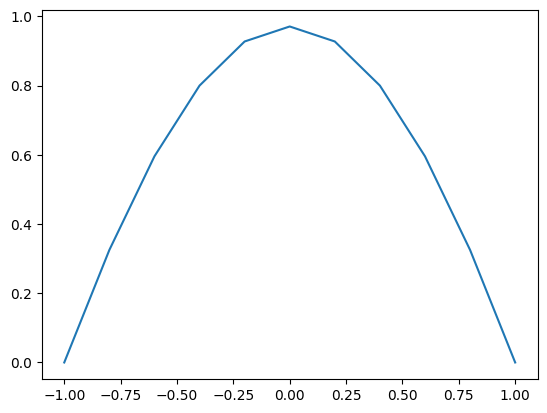

In [ ]:
solver.plot_solution()
solver.get_accuracy(Metrics.l_infinity_norm)

In [ ]:
h, error = solver.get_solution_according_accuracy(Metrics.l_infinity_norm)
print(
    f"Шаг, при котором достигается точность порядка {eps}, равен {h=}, при этом ошибка равна {error=}"
)

Шаг, при котором достигается точность порядка 0.001, равен h=0.0779999999999999, при этом ошибка равна error=0.0009871011626104338


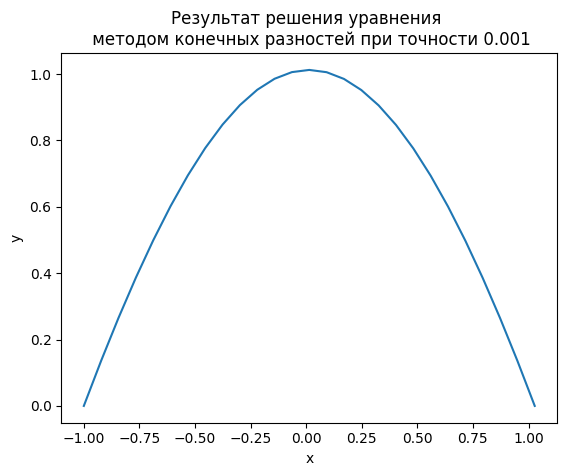

In [ ]:
plt.title(
    f"Результат решения уравнения \n методом конечных разностей при точности {eps}"
)
plt.xlabel("x")
plt.ylabel("y")
solver.plot_solution(mode="smooth")

Рассмотрим зависимость ошибки от шага сетки $h$. Для этого решим задачу для нескольких значений $h$ и построим график изменения значения ошибки:

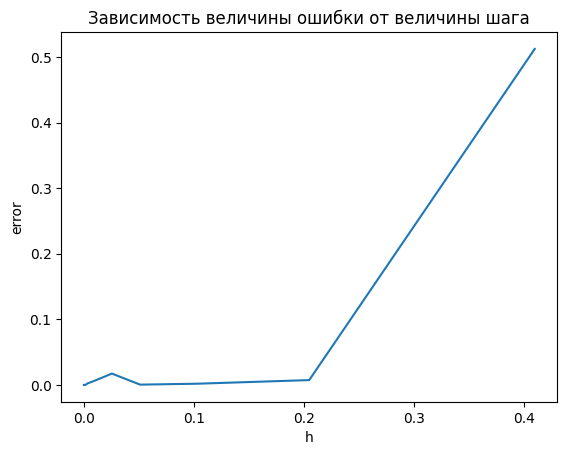

In [ ]:
h_value = 0.0001 * 2 ** np.arange(13)
errors = list()

for h in h_value:
    solver = SecondOrderSchemeSolver(
        lambda x: 0,
        lambda x: (1 + b * x ** 2) / a,
        lambda x: -1 / a,
        -1,
        1,
        h=h,
        left_condition=A,
        right_condition=B,
    )
    solver.solve()
    errors.append(solver.get_accuracy(Metrics.l_infinity_norm))


plt.title("Зависимость величины ошибки от величины шага")
plt.xlabel("h")
plt.ylabel("error")
plt.plot(h_value, errors)

## **Задача 2**

Найти приближенное решение краевой задачи методом конечных разностей:
$$ u'' + p(x)u' + q(x)u = f(x), x \in (a, b)$$
$$ u(a) = U_a, u(b) = U_b $$

### Решение задачи 2

1. Cоставить разностную схему второго порядка точности и выписать коэффициенты матрицы системы уравнений и коэффициенты правой части. 

За основу решение задачи был взят класс `SecondOrderSchemeSolver` в котором уже есть весь необходимый функционал для решения данной задачи


In [ ]:
p = lambda x: log(1 + x)
q = lambda x: 5 / (1 + x)
f = lambda x: 5 / (1 + x)
left_bound, left_condition = 0, 0
right_bound, right_condition = 2, 5
eps = 0.05

2. Подготовить тестовый пример и провести расчет для него. Построить на одном чертеже графики приближенного и точного решений для тестового примера. После проверки правильности работы программы перейти к решению основной задачи. 

В качестве тестового примера рассмотрим краевую задачу вида:
$$ x^2y'' - 2xy' + 2y = x^2 + 1, x \in (2, 5)$$
$$ y(2) = 1.3 $$ 
$$ y(5) = 2.4 $$
Аналитическим решением данной задачи является функция:
$$ y(x) = -1.227x^2 + 3.468x + x^2(\ln x - 1) + \frac{1}{2} $$ 

In [ ]:
p = lambda x: -2 / x
q = lambda x: 2 / (x ** 2)
f = lambda x: 1 + 1 / (x ** 2)

left_bound, left_condition = 2, 1.3
right_bound, right_condition = 5, 2.4

In [ ]:
solver = SecondOrderSchemeSolver(
    p,
    q,
    f,
    left_bound,
    right_bound,
    amount_points=100,
    left_condition=left_condition,
    right_condition=right_condition,
)
solver.solve()

In [ ]:
analytic_solution = (
    lambda x: -1.22696 * x ** 2 + 3.46762 * x + x ** 2 * (log(x) - 1) + 1 / 2.0
)

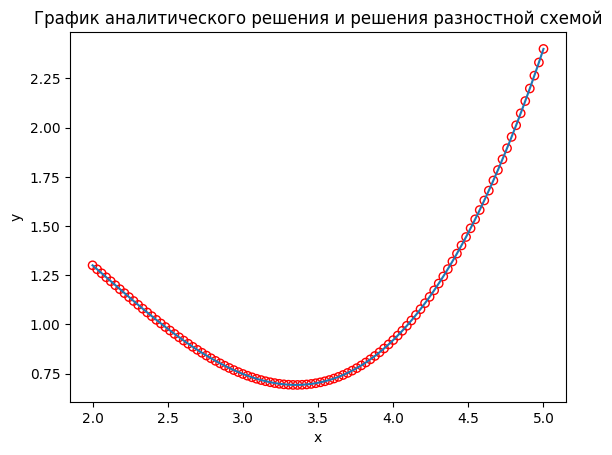

In [ ]:
plt.title("График аналитического решения и решения разностной схемой")
plt.xlabel("x")
plt.ylabel("y")

x = np.linspace(2, 5, 1000)
plt.plot(x, np.vectorize(analytic_solution)(x))
solver.plot_solution(mode="scatter")
plt.show()

In [ ]:
print(
    f"Ошибка для тестового примера {Metrics.l_infinity_norm(np.vectorize(analytic_solution)(solver.x_points), solver.y_points)}"
)

Ошибка для тестового примера 9.587405519007053e-05


3. Для отыскания решения задачи с заданной точностью произвести расчет с начальным шагом $h$, затем уменьшить шаг вдвое. Вывести на экран два соседних приближенных решения и сравнить результаты. Если заданная точность не достигнута, то продолжить уменьшение шага.
Условие исходя из номера варианта:
$$p(x) = \ln(1 + x) \\
q(x) = \frac{5}{1 + x} \\
f(x) = \frac{5}{1 + x} \\
a = 0, b = 2 \\
U_a = 5, U_b = 0 $$

In [ ]:
p = lambda x: log(1 + x)
q = lambda x: 5 / (1 + x)
f = lambda x: 5 / (1 + x)
left_bound = 0
right_bound = 2
left_condition = 5
right_condition = 0
eps = 0.05

In [ ]:
solver_h_2 = SecondOrderSchemeSolver(
    p,
    q,
    f,
    left_bound,
    right_bound,
    h=0.2,
    left_condition=left_condition,
    right_condition=right_condition,
)
solver_h_2.solve()

solver_h_1 = SecondOrderSchemeSolver(
    p,
    q,
    f,
    left_bound,
    right_bound,
    h=0.1,
    left_condition=left_condition,
    right_condition=right_condition,
)
solver_h_1.solve()

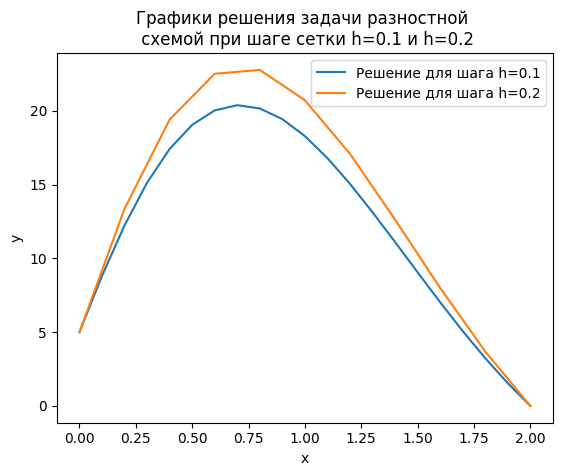

In [ ]:
plt.title("Графики решения задачи разностной \n схемой при шаге сетки h=0.1 и h=0.2")
plt.xlabel("x")
plt.ylabel("y")

solver_h_1.plot_solution("smooth")
solver_h_2.plot_solution("smooth")
plt.legend(["Решение для шага h=0.1", "Решение для шага h=0.2"])
plt.show()

 4. Построить график найденного решения и указать шаг, при котором заданная точность достигается.


In [ ]:
solver = SecondOrderSchemeSolver(
    p,
    q,
    f,
    left_bound,
    right_bound,
    h=0.7,
    left_condition=left_condition,
    right_condition=right_condition,
)
solver.solve()
h, error = solver.get_solution_according_accuracy(Metrics.l_infinity_norm, eps=eps)
print(
    f"Шаг, при котором достигается точность порядка {eps}, равен {h=}, при этом ошибка равна {error=}"
)

Шаг, при котором достигается точность порядка 0.05, равен h=0.020999999999999353, при этом ошибка равна error=0.04019893808999934


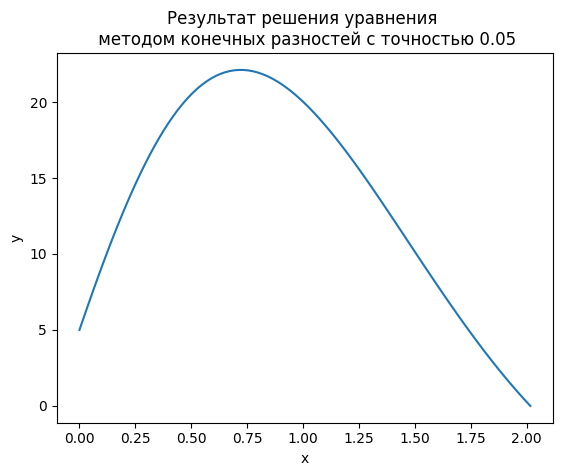

In [ ]:
plt.title(
    f"Результат решения уравнения \n методом конечных разностей с точностью {eps}"
)
plt.xlabel("x")
plt.ylabel("y")
solver.plot_solution(mode="smooth")

## **Задача 3**

1. Использовать разностную схему второго порядка точности. Для аппроксимации производных в граничных условиях воспользоваться разностными отношениями: $$ y'_0 = \frac{-y_2 + 4y_1 - 3y_0}{2h} $$
$$ y'_n = \frac{3y_n - 4y_{n-1} + y_{n-2}}{2h} $$
Для решения задачи был разработан класс `SecondOrderSchemeSolverBoundaryConditions` основанный на классе `SecondOrderSchemeSolver`. Система линейных уравнений для решения задачи основана на аналогичной для класса `SecondOrderSchemeSolver`, однако здесь учитывается пересчет коэффициентов матрицы (в силу того что в данной задаче решается краевая задача третьего рода) для привидения ее в трехдиагональный вид.

In [ ]:
class SecondOrderSchemeSolverBoundaryConditions(SecondOrderSchemeSolver):
    def __init__(
        self,
        p_function,
        q_function,
        f_function,
        left_bound,
        right_bound,
        h=0.1,
        amount_points=None,
        left_condition=None,
        right_condition=None,
    ):
        super().__init__(
            p_function,
            q_function,
            f_function,
            left_bound,
            right_bound,
            h=h,
            amount_points=amount_points,
            left_condition=left_condition[0],
            right_condition=right_condition[0],
        )
        self.left_condition_function = left_condition[1]
        self.left_condition_derivative_function = left_condition[2]

        self.right_condition_function = right_condition[1]
        self.right_condition_derivative_function = right_condition[2]

    def get_accuracy(self, metrics):
        if self.y_points is None:
            raise ValueError
        left_condition = (
            self.left_condition,
            self.left_condition_function,
            self.left_condition_derivative_function,
        )
        right_condition = (
            self.right_condition,
            self.right_condition_function,
            self.right_condition_derivative_function,
        )

        double_h_solver = self.__class__(
            self.p,
            self.q,
            self.f,
            self.left_bound,
            self.right_bound,
            h=self.h * 2.0,
            left_condition=left_condition,
            right_condition=right_condition,
        )
        double_h_solver.solve()
        return metrics(
            self.y_points[::2],
            double_h_solver.y_points
            if self.y_points.size % 2 == 1
            else double_h_solver.y_points[:-1],
        ) / (2 ** self._order - 1)

    def _get_difference_scheme_vectors(self):
        (
            upper_diagonal,
            diagonal,
            lower_diagonal,
            result,
        ) = super()._get_difference_scheme_vectors()

        diagonal[0] = (
            (-3 / 2.0 + lower_diagonal[0] / (2 * upper_diagonal[1]))
            * self.left_condition_derivative_function
            + self.left_condition_function * self.h
        )
        upper_diagonal[0] = (
            2 + diagonal[1] / (2 * upper_diagonal[1])
        ) * self.left_condition_derivative_function
        result[0] += (
            result[1]
            * self.left_condition_derivative_function
            / (2 * upper_diagonal[1])
        )

        lower_diagonal[-1] = (
            -2 - diagonal[-2] / (2.0 * lower_diagonal[-2])
        ) * self.right_condition_derivative_function
        diagonal[-1] = (
            (3 / 2 - upper_diagonal[-1] / (2.0 * lower_diagonal[-2]))
            * self.right_condition_derivative_function
            + self.right_condition_function * self.h
        )
        result[-1] -= (
            result[-2] / (2.0 * lower_diagonal[-2])
        ) * self.right_condition_derivative_function

        return upper_diagonal, diagonal, lower_diagonal, result

2. Организовать компактное хранение ненулевых элементов трехдиагональной матрицы системы разностных уравнений. 

В силу того, что класс `SecondOrderSchemeSolverBoundaryConditions` наследуется от `SecondOrderSchemeSolver` решение системы уравнений происходит при помощи метода прогонки, который работает с тремя векторами и не требует дополнительный затрат по памяти.

3. Подготовить самостоятельно тестовый пример и провести расчет для него. Построить на одном чертеже графики приближенного и точного решений для тестового примера. После проверки правильности работы программы перейти к решению основной задачи.


В качестве тестового примера рассмотрим краевую задачу третьго рода:
$$ \left( {x - 1} \right)y'' - xy' + y = {\left( {x - 1} \right)^2}, 2 \le x \le 4$$
$$ y'(2) = 2 $$
$$ y'(4) + 2y(4) = 5$$
Применив формулу Лиувилля-Остроградского можно получить общее решение уравнения:
$$ y(x) = {{A_1}{e^x} + {A_2}x - {x^2} - x - 1}$$ 
Найдем коэффициенты $A_1$ и $A_2$ при помощи краевых условий третьего рода:
$$ A_1e^2 + A_2 - 4 - 1 = 2$$
$$ 3A_1e^{4} + 9A_2 - 51 = 5 $$
Получим систему линейных уравнений:
$$ 7.4A_1 + A_2 = 7$$
$$ 163.8A_1 + 9A_2 = 56 $$
Решив ее получим коэффициенты $A_1=-0.072$ и $A_2 = 7.532$. Решение примет вид:
$$y(x) = {-0.072{e^x} + 7.532x - {x^2} - x - 1} $$

In [ ]:
analytic_solution = lambda x: -0.072 * exp(x) + 7.532 * x - x ** 2 - x - 1

Решим данную задачу при помощи разностной схемы:

In [ ]:
p_test = lambda x: -x / (x - 1)
q_test = lambda x: 1 / (x - 1)
f_test = lambda x: (x - 1)

left_bound = 2
left_condition = (lambda h: h * 2, 0, 1)

right_bound = 4
right_condition = (lambda h: h * 5, 2, 1)

In [ ]:
solver = SecondOrderSchemeSolverBoundaryConditions(
    p_test,
    q_test,
    f_test,
    left_bound,
    right_bound,
    amount_points=100,
    left_condition=left_condition,
    right_condition=right_condition,
)
solver.solve()

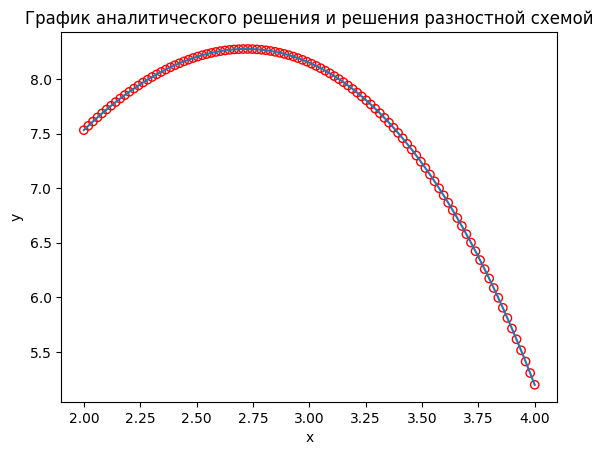

In [ ]:
plt.title("График аналитического решения и решения разностной схемой")
plt.xlabel("x")
plt.ylabel("y")

x = np.linspace(2, 4, 1000)
plt.plot(x, np.vectorize(analytic_solution)(x))
solver.plot_solution(mode="scatter")
plt.show()

In [ ]:
print(
    f"Ошибка для тестового примера {Metrics.l_infinity_norm(np.vectorize(analytic_solution)(solver.x_points), solver.y_points)}"
)

Ошибка для тестового примера 0.0010788749297834244


Теперь рассмотрим краевую задачу третьего рода указанного в задании:
$$u'' + {{u'} \over {x}} + u = 2x$$
$$u(1.5) + 0.5 u'(1.5) = 1.5$$
$$u'(4.5) = 5 $$


In [ ]:
p = lambda x: 1 / x
q = lambda x: 1
f = lambda x: 2 * x

left_bound = 1.5
right_bound = 4.5

left_condition = (lambda h: 1.5 * h, 1, 0.5)
right_condition = (lambda h: 5 * h, 0, 1)
eps = 0.05

In [ ]:
solver = SecondOrderSchemeSolverBoundaryConditions(
    p,
    q,
    f,
    left_bound,
    right_bound,
    h=0.6,
    left_condition=left_condition,
    right_condition=right_condition,
)
solver.solve()
h, error = solver.get_solution_according_accuracy(Metrics.l_infinity_norm, eps=eps)
print(
    f"Шаг, при котором достигается точность порядка {eps}, равен {h=}, при этом ошибка равна {error=}"
)

Шаг, при котором достигается точность порядка 0.05, равен h=0.46699999999999986, при этом ошибка равна error=0.0481341808055474


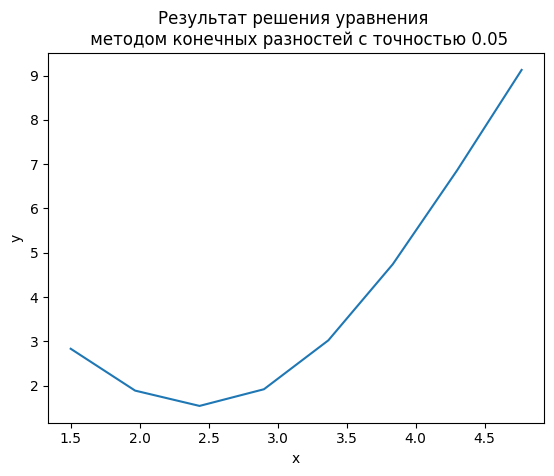

In [ ]:
plt.title(
    f"Результат решения уравнения \n методом конечных разностей с точностью {eps}"
)
plt.xlabel("x")
plt.ylabel("y")
solver.plot_solution(mode="smooth")

## **Задача 4**

Методом конечных разностей найти приближенное решение краевой задачи с тремя верными значащими цифрами. Решение системы разностных уравнений найти, используя метод прогонки 
$$ (-k(x)u')' + q(x)u = f(x), x \in (a, b) \\
-k(a)u'(a) + 0.5u(a) = 0 \\
k(b)u'(b) + 0.5u(b) = 0 $$

1.Использовать разностную схему второго порядка точности 

Решение реализовано в виде класса `SecondOrderSchemeSolverBalanceMethod`, наследованного от класса `AbstractDifferenceSchemeSolver`, в котором переопределена функция инициализации и функия определения трехдиагональной системы линейных уравнений для конкретной граничной задачи третьего рода. Разностная схема в данном классе имеет второй порядок точности 

2.При аппроксимации производных в граничных условиях использовать метод баланса.

Для приближения прозводной в граничных условиях используем метод баланса, который уже включен в реализацию функции `_get_difference_scheme_vectors`

In [ ]:
class SecondOrderSchemeSolverBalanceMethod(AbstractDifferenceSchemeSolver):
    def __init__(self, k_function, q_function, f_function, left_bound, right_bound, h):
        self.k = k_function
        self.q = q_function
        self.f = f_function

        self.left_bound = left_bound
        self.right_bound = right_bound
        self.left_condition = 0
        self.right_condition = 0

        self.h = h

        self.x_points = np.arange(self.left_bound, self.right_bound + self.h, self.h)
        self.y_points = None
        self._order = 2

    def get_accuracy(self, metrics):
        if self.y_points is None:
            raise ValueError
        double_h_solver = self.__class__(
            self.k, self.q, self.f, self.left_bound, self.right_bound, h=self.h * 2.0
        )
        double_h_solver.solve()
        return metrics(
            self.y_points[::2],
            double_h_solver.y_points
            if self.y_points.size % 2 == 1
            else double_h_solver.y_points[:-1],
        ) / (2 ** self._order - 1)

    def _get_difference_scheme_vectors(self):
        diagonal = np.zeros(self.x_points.size)
        lower_diagonal = np.zeros(self.x_points.size - 1)
        upper_diagonal = np.zeros(self.x_points.size - 1)

        result = np.zeros(self.x_points.size)
        result[1:-1] = np.vectorize(lambda x: self.h ** 2 * self.f(x))(
            self.x_points[1:-1]
        )

        diagonal[1:-1] = np.vectorize(
            lambda x: 2 * self.k(x) + self.q(x) * self.h ** 2
        )(self.x_points[1:-1])
        lower_diagonal[:-1] = np.vectorize(lambda x: -self.k(x))(self.x_points[1:-1])
        upper_diagonal[1:] = np.vectorize(lambda x: -self.k(x))(self.x_points[1:-1])

        diagonal[0] = self.h / 4.0 + self.k(self.left_bound)
        upper_diagonal[0] = self.h / 4.0 - self.k(self.left_bound)

        diagonal[-1] = self.h / 4.0 + self.k(self.right_bound)
        lower_diagonal[-1] = self.h / 4.0 - self.k(self.right_bound)

        return upper_diagonal, diagonal, lower_diagonal, result

Решим задачу исходя из варианта:
$$ a = 0, b = 2.5, c = 1.515$$
$$ k(x) 
   = \begin{cases}
        0.3,  x \in (a, c)
        \\
        1.8,  x \in (c, b)
        \end{cases} $$
 
 $$ q(x)
   = \begin{cases}
        3.5,  x \in (a, c)
        \\
        8.3,  x \in (c, b)
        \end{cases}$$
$$ f(x) = 10 x (1.5 − 0.3 x^2 ) $$

In [ ]:
a = 0
b = 2.5
c = 1.515
k = lambda x: 0.3 if a <= x < c else 1.8
q = lambda x: 3.5 if a <= x < c else 8.3
f = lambda x: 10 * x * (1.5 - 0.3 * x ** 2)
eps = 0.001

In [ ]:
solver = SecondOrderSchemeSolverBalanceMethod(k, q, f, a, b, h=0.7)
solver.solve()

In [ ]:
h, error = solver.get_solution_according_accuracy(Metrics.l_infinity_norm, eps=eps)
print(
    f"Шаг, при котором достигается точность порядка {eps}, равен {h=}, при этом ошибка равна {error=}"
)

Шаг, при котором достигается точность порядка 0.001, равен h=0.0009999999999993408, при этом ошибка равна error=0.0006158780649786477


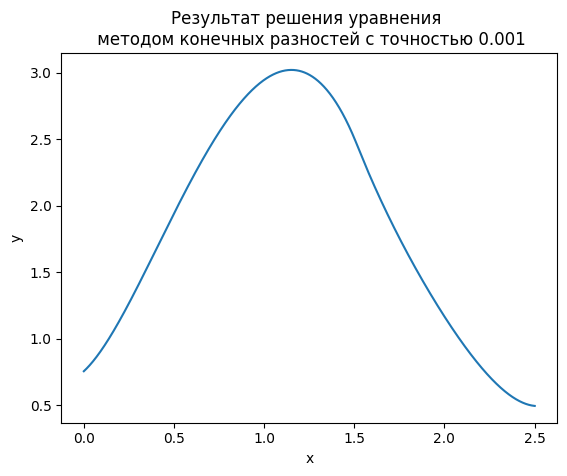

In [ ]:
plt.title(
    f"Результат решения уравнения \n методом конечных разностей с точностью {eps}"
)
plt.xlabel("x")
plt.ylabel("y")
solver.plot_solution(mode="smooth")

## Вывод

В ходе лабораторной работы я изучил метод разностных аппроксимаций с вторым порядком точности для краевых задач первого и третьего рода. При этом для приближения краевых условий использовались правые и левые формулы конечных разностей второго порядка для задачи 3 и метод баланса (приближение при помощи метода центральных прямоугольников) для задачи 4.

Реализация программы выполненна при помощи иерархии классов для решения задач, упрощяющих процесс разработки и тестирования программного продукта. При этом для оптимизации памяти и скорости в каждом из классов разностная схема хранится в виде трех векторов-диагоналей, решение трехдиагональной системы происходит при помощи метода прогонки.

Я получил численное решение заданных краевых задач с заданными точностями, при этом ошибка вычисляется по правилу Рунге с указанием требуемой метрики. Рассмотрев несколько решений для различного параметра шага $h$ я удостоверился о том, что порядок решения данных разностных схем $O(h^2)$.

Также я разработал и выполнил тестовые задачи, сравнил результаты работы алгоритмов с аналитическими формулами решения задачи, тем самым проверил корректность работы программного продукта.